In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage.morphology as morphology
from operator import itemgetter

/home/francesco/anaconda3/envs/IPCV/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load SIFT detector
sift = cv2.SIFT_create()
images_path = '/home/francesco/Projects/Product Recognition on Store Shelves/images'

In [4]:
products_description = {
    '0.jpg': 'Nesquik no scritte',
    '1.jpg': 'ChocoKrave blu',
    '2.jpg': 'CornFlakes',
    '3.jpg': 'ChokoGoal',
    '4.jpg': 'SlimChocolate',
    '5.jpg': 'Nesquik cereali',
    '6.jpg': 'Nesquik duo',
    '7.jpg': 'CocoPops risociok',
    '8.jpg': 'CocoPops palline rosso',
    '9.jpg': 'SpecialK classic',
    '10.jpg': 'SpecialK fondente',
    '11.jpg': 'ChocoKrave',
    '12.jpg': 'Fitness fruits',
    '13.jpg': 'Fitness azzurro',
    '14.jpg': 'Chocapic',
    '15.jpg': 'CocoPops rotelle',
    '16.jpg': 'MielPops nocciola',
    '17.jpg': 'MielPops anellini',
    '18.jpg': 'CountryCrisp',
    '19.jpg': 'CountryCrisp nuts azzurro',
    '20.jpg': 'SpecialK frutti rossi',
    '21.jpg': 'RiceKrispies',
    '22.jpg': 'Cheerios',
    '23.jpg': 'SpecialK classic',
    '24.jpg': 'Fitness pink edition',
    '25.jpg': 'CocoPops palline rosso con regalo',
    '26.jpg': 'Nesquik duo con regalo fucsia',
}

In [5]:
def match(model, scene, threshold=0.75, k=2):
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)

    # Initializing matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching and finding the 2 closest elements for each query descriptor.
    matches = flann.knnMatch(model, scene, k)
    #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good_matches = []
    for m,n in matches:
        if m.distance < threshold * n.distance: #  if m.distance/n.distance < Threshold:
            good_matches.append(m)
            
    return good_matches

def nms(boxes, scores, overlapThresh):
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # Initialize the list of picked indexes
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # Compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list and add the index
        # value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the largest (x, y) coordinates for the start of the bounding box
        # and the smallest (x, y) coordinates for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # Compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # Delete all indexes from the index list that have a large overlap
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked
    return boxes[pick], pick


In [6]:
def image_to_color_bins_lab(image_path, grid_size=(4, 4), roi=None):
    # Read the image and convert it to the LAB color space
    image = cv2.imread(image_path)

        # If a region of interest is provided, crop the image to that region
    if roi is not None:
        x, y, w, h = roi
        image = image[y:y+h, x:x+w]
        # print(f'Now image size is {image.size}')
        if image.size == 0:
            return
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()
        
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    image_height, image_width, _ = lab_image.shape

    # Calculate the size of each bin
    bin_height = image_height // grid_size[0]
    bin_width = image_width // grid_size[1]
    # List to hold the average color per bin
    average_colors = []

    # Loop over the grid
    for i in range(0, image_height, bin_height):
        if i + bin_height > image_height:
            continue
        for j in range(0, image_width, bin_width):
            if j + bin_width > image_width:
                continue
            # Compute the boundaries of the bin
            bin_roi = lab_image[i:i+bin_height, j:j+bin_width]

            # Compute the average color of the bin
            average_color = cv2.mean(bin_roi)[:3]  # Slice to exclude the alpha channel if present
            average_colors.append(average_color)
    # return np.array(average_colors)
    v = np.array(average_colors)
    return cv2.normalize(v, v).flatten()

def cosine_distance(a, b):
    # Compute the cosine similarity
    cosine_similarity = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    # Compute the cosine distance
    distance = 1 - cosine_similarity
    return distance

def compute_iou(rect_a, rect_b):
    # Unpack the coordinates
    min_x_a, max_x_a, min_y_a, max_y_a = rect_a
    min_x_b, max_x_b, min_y_b, max_y_b = rect_b

    # Calculate the intersection coordinates
    intersection_min_x = max(min_x_a, min_x_b)
    intersection_max_x = min(max_x_a, max_x_b)
    intersection_min_y = max(min_y_a, min_y_b)
    intersection_max_y = min(max_y_a, max_y_b)

    # Calculate the area of intersection
    intersection_area = max(0, intersection_max_x - intersection_min_x) * max(0, intersection_max_y - intersection_min_y)

    # Calculate the area of both rectangles
    area_a = (max_x_a - min_x_a) * (max_y_a - min_y_a)
    area_b = (max_x_b - min_x_b) * (max_y_b - min_y_b)

    # Calculate the area of the union
    union_area = area_a + area_b - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    
    return iou

In [7]:
def calc_histogram(image_path, bins_per_channel=32, roi=None):
    # Read the image
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    
    # If a region of interest is provided, crop the image to that region
    if roi is not None:
        x, y, w, h = roi
        image = image[y:y+h, x:x+w]
        # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # plt.show()

    # Calculate the histogram for each color channel using the specified number of bins
    histogram = cv2.calcHist([image], [0, 1, 2], None, [bins_per_channel]*3, [0, 256, 0, 256, 0, 256])
    # Normalize and flatten the histogram for comparison
    return cv2.normalize(histogram, histogram).flatten(), image

# Function to compare two histograms
def compare_histograms(hist1, hist2, method=cv2.HISTCMP_CORREL):
    score = cv2.compareHist(hist1, hist2, method)
    return score

# STEP 2

## Initialization
Set up sift

In [8]:
sift = cv2.SIFT_create()

Set up images to use

In [10]:
def match(model, scene, threshold=0.75, k=2, matcher='flann'):
    FLANN_INDEX_KDTREE = 1

    # Defining parameters for algorithm 
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    # Defining search params.
    # checks=50 specifies the number of times the trees in the index should be recursively traversed.
    # Higher values gives better precision, but also takes more time
    search_params = dict(checks = 50)
    
    # Initializing matcher
    if matcher == 'bf':
        matcher = cv2.BFMatcher(index_params, search_params)
    else:
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
    # Matching and finding the 2 closest elements for each query descriptor.
    matches = matcher.knnMatch(model, scene, k)
    #defining an array containing all the matches that results to be considered "good" matches applying a certain treshold 
    good_matches = {}

    for m, n in matches:
        if m.distance < threshold * n.distance:
            good_matches[m.queryIdx] = m.trainIdx

    return good_matches

def create_hough_space(good_matches, kp_query, kp_train, query_xc, query_yc):
    def map_entry_to_hough_space(kp_q, kp_t, q_xc, q_yc):

        entry = {}
    
        v = ((q_xc - kp_q.pt[0]), (q_yc - kp_q.pt[1]))
        scale_ratio = kp_t.size / kp_q.size
        delta_angle = kp_t.angle - kp_q.angle
        x_c = kp_t.pt[0] + scale_ratio * (np.cos(delta_angle) * v[0] - np.sin(delta_angle) * v[1])
        y_c = kp_t.pt[1] + scale_ratio * (np.sin(delta_angle) * v[0] + np.cos(delta_angle) * v[1])
    
        entry['x_c'] = x_c
        entry['y_c'] = y_c
        entry['scale_ratio'] = scale_ratio
        entry['delta_angle'] = delta_angle
        
        return entry 
    # map of hough space kp_train_idx -> map name-values
    hough_space = {}

    for t_idx, q_idx in good_matches.items():
        hough_space[t_idx] = map_entry_to_hough_space(kp_query[q_idx], kp_train[t_idx], query_xc, query_yc)
    
    return hough_space

def compute_bins(hough_space,query_shape,train_shape, bin_precision=0.25, angle_bin_size=0.1, angle_bins=8, scale_bin_size=0.1):

    values = {}
    
    data_scale = [entry['scale_ratio'] for entry in hough_space.values()]
    counts_scale, bins_scale, patches_size = plt.hist(data_scale, bins='auto')
    img_scale = np.mean([bins_scale[np.argmax(counts_scale)], bins_scale[np.argmax(counts_scale) + 1]])
    plt.close()

    data_angle = [entry['delta_angle'] for entry in hough_space.values()]
    counts_angle, bins_angle, patches_angle = plt.hist(data_angle, bins='auto')
    plt.close()

    x_bin_size = img_scale * query_shape[1] * bin_precision
    y_bin_size = img_scale * query_shape[0] * bin_precision
    x_bins = int(np.ceil(train_shape[1] / x_bin_size) + 2)
    y_bins = int(np.ceil(train_shape[0] / y_bin_size) + 2)
    x_min = train_shape[1] / 2 - x_bins / 2 * x_bin_size
    y_min = train_shape[0] / 2 - y_bins / 2 * y_bin_size

    angle_bin_size = np.std(data_angle) * angle_bin_size
    angle_bin_center = np.mean(data_angle)
    angle_min = angle_bin_center - angle_bins / 2 * angle_bin_size
    angle_max = angle_bin_center + angle_bins / 2 * angle_bin_size

    scale_bin_size = np.std(data_scale) * scale_bin_size
    scale_bin_center = np.mean(data_scale)
    scale_min = 0 
    scale_max = scale_bin_center * 2 
    scale_bins = int((scale_max - scale_min) / scale_bin_size)

    values['x_bins'] = x_bins
    values['y_bins'] = y_bins
    values['x_min'] = x_min
    values['y_min'] = y_min
    values['x_bin_size'] = x_bin_size
    values['y_bin_size'] = y_bin_size
    values['scale_bins'] = scale_bins
    values['scale_min'] = scale_min
    values['scale_bin_size'] = scale_bin_size
    values['angle_min'] = angle_min
    values['angle_bin_size'] = angle_bin_size  

    return values

def voting(b, h_s, angle_bins=8):

    accumulator = np.zeros((b['x_bins'], b['y_bins'], angle_bins, b['scale_bins']))

    votes = {}

    for idx, v in h_s.items():
        try:
            for x in range(0, 2):
                for y in range(0, 2):
                    for z in range(0, 2):
                        for w in range(0, 2):                
                            i = int(np.floor((v['x_c'] - b['x_min'] + (x - 1 / 2) * b['x_bin_size']) / b['x_bin_size']))
                            j = int(np.floor((v['y_c'] - b['y_min'] + (y - 1 / 2) * b['y_bin_size']) / b['y_bin_size']))
                            k = int(np.floor((v['delta_angle'] - b['angle_min'] + (z - 1 / 2) * b['angle_bin_size']) / b['angle_bin_size']))
                            l = int(np.floor((v['scale_ratio'] - b['scale_min'] + (w - 1 / 2) * b['scale_bin_size']) / b['scale_bin_size']))
                            if i >= 0 and j >= 0 and k >= 0 and l >= 0:
                                accumulator[i, j, k, l] += 1
                                votes[(i, j, k, l)] = votes.get((i, j, k, l), [])
                                votes[(i, j, k, l)].append(idx)
        except: pass
    
    return accumulator, votes   

In [11]:
HOUGH_THRESHOLD = 100

In [12]:
images_path

'/home/francesco/Projects/Product Recognition on Store Shelves/images'

In [39]:
product_images = ['0.jpg', '1.jpg', '11.jpg', '19.jpg', '24.jpg', '26.jpg', '25.jpg']

scene_images = ['m1.png', 'm2.png', 'm3.png', 'm4.png', 'm5.png']
# product_images = [f'{i}.jpg' for i in range(27)]
# scene_images = ['h1.jpg', 'h2.jpg', 'h3.jpg', 'h4.jpg', 'h5.jpg']

Scene m1.png
	Product 26 (Nesquik duo con regalo fucsia): 1 instance found:
		Instance 1 {position: (921, 230), width: 334px, height: 461px
	Product 25 (CocoPops palline rosso con regalo): 1 instance found:
		Instance 1 {position: (1262, 228), width: 309px, height: 435px
	Product 24 (Fitness pink edition): 2 instances found:
		Instance 1 {position: (184, 232), width: 351px, height: 463px
		Instance 2 {position: (550, 232), width: 334px, height: 463px


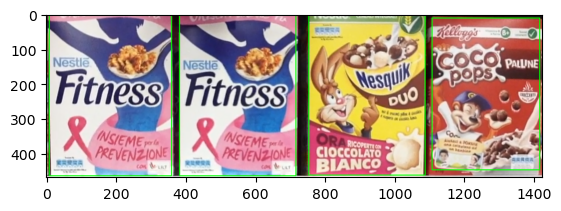

Scene m2.png
	Product 0 (Nesquik no scritte): 1 instance found:
		Instance 1 {position: (178, 300), width: 344px, height: 449px
	Product 1 (ChocoKrave blu): 2 instances found:
		Instance 1 {position: (1180, 254), width: 301px, height: 407px
		Instance 2 {position: (848, 258), width: 313px, height: 410px
	Product 25 (CocoPops palline rosso con regalo): 1 instance found:
		Instance 1 {position: (512, 287), width: 319px, height: 416px


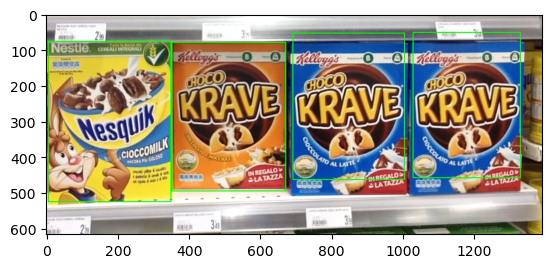

Scene m3.png
	Product 19 (CountryCrisp nuts azzurro): 1 instance found:
		Instance 1 {position: (1232, 190), width: 296px, height: 381px
	Product 26 (Nesquik duo con regalo fucsia): 1 instance found:
		Instance 1 {position: (195, 230), width: 354px, height: 459px
	Product 25 (CocoPops palline rosso con regalo): 2 instances found:
		Instance 1 {position: (558, 224), width: 335px, height: 447px
		Instance 2 {position: (890, 280), width: 361px, height: 543px


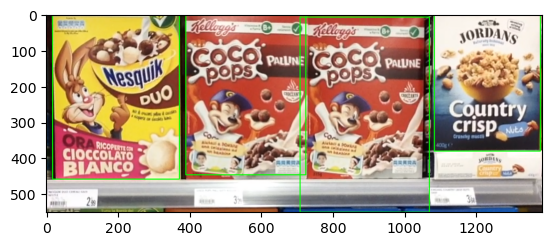

Scene m4.png
	Product 26 (Nesquik duo con regalo fucsia): 1 instance found:
		Instance 1 {position: (922, 221), width: 341px, height: 442px
	Product 25 (CocoPops palline rosso con regalo): 2 instances found:
		Instance 1 {position: (1272, 218), width: 325px, height: 437px
		Instance 2 {position: (1584, 263), width: 345px, height: 526px
	Product 24 (Fitness pink edition): 2 instances found:
		Instance 1 {position: (540, 222), width: 350px, height: 445px
		Instance 2 {position: (171, 222), width: 342px, height: 445px


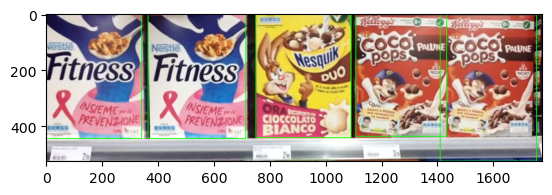

Scene m5.png
	Product 1 (ChocoKrave blu): 2 instances found:
		Instance 1 {position: (500, 720), width: 314px, height: 411px
		Instance 2 {position: (832, 717), width: 302px, height: 410px
	Product 25 (CocoPops palline rosso con regalo): 2 instances found:
		Instance 1 {position: (233, 226), width: 336px, height: 452px
		Instance 2 {position: (565, 232), width: 322px, height: 453px
	Product 19 (CountryCrisp nuts azzurro): 1 instance found:
		Instance 1 {position: (908, 191), width: 295px, height: 382px
	Product 11 (ChocoKrave): 1 instance found:
		Instance 1 {position: (163, 714), width: 310px, height: 401px


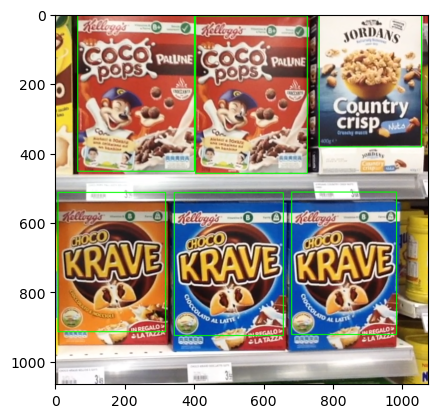

In [40]:
for train_image_name in scene_images:
    print(f'Scene {train_image_name}')
    train_image = cv2.imread(images_path + '/scenes/' + train_image_name, 0)
    train_image_color = cv2.imread(images_path + '/scenes/' + train_image_name)
    kp_train, des_train = sift.detectAndCompute(train_image, None)
    correspondences = list()
    # training phase
    for query_image_name in product_images:
        query_image = cv2.imread(images_path + '/models/' + query_image_name)
        kp_query, des_query = sift.detectAndCompute(query_image, None)
        
        good_matches = match(des_train, des_query)
        # barycenter of found query keypoint 
        query_xc = np.mean(list(kp_query[p].pt[0] for _, p in good_matches.items()))
        query_yc = np.mean(list(kp_query[p].pt[1] for _, p in good_matches.items()))
        
        hough_space = create_hough_space(good_matches, kp_query, kp_train, query_xc, query_yc)
        
        if len(hough_space) < HOUGH_THRESHOLD:
            continue

        bins_values = compute_bins(hough_space, query_image.shape, train_image.shape)

        # create and populate accumulator with voting by each entry of the hough space 
        accumulator, votes= voting(bins_values, hough_space)

        # compute local maxima of the 4-dimensional accumulator 
        mask = morphology.local_maxima(accumulator)
        accumulator[mask != 1] = 0

        # store in a list all the correspondeces between query points and train points that voted for a local maxima 
        # the list contains: number of votes that a local maxima bin has received, name of query image, list of query and train keypoints which voted for that bin
        for b in list(np.argwhere(accumulator >= 5)): # thresholding the accumulator to come up with few maxima 
            keypoint_index_list = votes[tuple(b)] # all query keypoint who voted for a local maxima bin 
            correspondence_list = [(kp_train[k], kp_query[good_matches[k]]) for k in keypoint_index_list]
            correspondences.append([accumulator[tuple(b)], query_image_name, correspondence_list])
    correspondences = sorted(correspondences, key=itemgetter(0), reverse=True)
    # matching phase
    
    results = dict()
    for correspondence in correspondences:
        query_image = cv2.imread(images_path + '/models/' + correspondence[1], 0)
        # compute homography through correspondent keypoints
        try:
            src_pts = np.float32([e[1].pt for e in correspondence[2]]).reshape(-1, 1, 2)
            dst_pts = np.float32([e[0].pt for e in correspondence[2]]).reshape(-1, 1, 2)
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            h, w = query_image.shape
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts, M)
        except:
            continue

        # determine center of the train ROI matching with the image query
        center = tuple((dst[0, 0, i] + dst[1, 0, i] + dst[2, 0, i] + dst[3, 0, i]) / 4 for i in (0, 1))

        # determine extreme points of the quadrilateral shape of query image projected into train scene
        x_min = int(max((dst[0,0,0] + dst[1,0,0]) / 2, 0))
        y_min = int(max((dst[0,0,1] + dst[3,0,1]) / 2, 0))
        x_max = int(min((dst[2,0,0] + dst[3,0,0]) / 2, train_image.shape[1]))
        y_max = int(min((dst[1,0,1] + dst[2,0,1]) / 2, train_image.shape[0]))
        width = x_max - x_min
        height = y_max - y_min
        
        if width > height:
            continue
        # compute main color of both query and train ROI to tell similar boxes apart
        query_color = query_image.mean(axis=0).mean(axis=0)
        train_crop = train_image_color[y_min:y_max, x_min:x_max]
        if train_crop.shape[0] == 0 and train_crop.shape[1] == 0:
            continue
        # print(f'Train crop shape: {train_crop.shape}')
        grid_size = (8, 8)
        product_colors = image_to_color_bins_lab(images_path + '/models/' + correspondence[1], grid_size=grid_size)
        patch_colors = image_to_color_bins_lab(images_path + '/scenes/' + train_image_name, roi=(x_min, y_min, width, height), grid_size=grid_size)
                # Continue with comparison as before...
        try:
            color_distance = cosine_distance(product_colors, patch_colors)
        except TypeError:
            continue
        except ValueError:
            continue
        temp = True

        if color_distance >= 0.020:
            # detection_mask[min_y:max_y, min_x:max_x] = 0
            # scene_kp, scene_des = sift.detectAndCompute(scene_img, detection_mask)
            # plt.imshow(detection_mask)
            # plt.show()
            # print(f'\tProduct {img_name} ({products_description[img_name]}) - color distance is too high! {color_distance:.3f}')
            continue
        else:
            to_ignore = False
            for result in results.copy():
                iou = compute_iou(result, (x_min, x_max, y_min, y_max))
                if iou >= 0.3:
                    if results[result]['votes'] > correspondence[0]:
                        to_ignore = True
                    else:
                        results.pop(result)
                    
            if not to_ignore:  
                results[(x_min, x_max, y_min, y_max)] = {'product': correspondence[1], 'votes': correspondence[0]}
    
    results_by_product = dict()
    for result in results:
        if results[result]['product'] not in results_by_product:
            results_by_product[results[result]['product']] = [result, ]
        else:
            results_by_product[results[result]['product']].append(result)

    for product in results_by_product:
        instances = len(results_by_product[product])
        print(f'\tProduct {product.split(".")[0]} ({products_description[product]}): {instances} instance{"s" if instances > 1 else ""} found:')
        for instance_iterator in range(instances):
            min_x, max_x, min_y, max_y = results_by_product[product][instance_iterator]
            width = max_x - min_x
            height = max_y - min_y
            center_x = min_x + (width / 2)
            center_y = min_y + (height / 2)

            print(f'\t\tInstance {instance_iterator+1} {{position: ({center_x:.0f}, {center_y:.0f}), width: {width}px, height: {height}px')
            train_image_color = cv2.rectangle(train_image_color, (min_x, min_y), (max_x, max_y), (0, 255, 0), 2)
    
    plt.imshow(cv2.cvtColor(train_image_color, cv2.COLOR_BGR2RGB))
    plt.show()